# DDPG Main

## Data Preprocessing

In [2]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.6 MB/s eta 0:00:00


In [59]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
#C:\Users\rohit\OneDrive\Documents\Asset-Pricing-with-Reinforcement-Learning\XOM_30_minute_6_month_data.csv
df = pd.read_csv('XOM_30_minute_6_month_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Normalize
scaler = MinMaxScaler()

df[['Last Price', 'Volume', 'SMAVG (15)']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)']])

# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print(train_df[10:])

                    Date  Last Price    Volume  SMAVG (15)
2331 2023-03-07 20:00:00    0.596608  0.049707    0.072420
2330 2023-03-07 20:30:00    0.606681  0.165330    0.086878
2329 2023-03-08 14:30:00    0.634154  0.134774    0.099523
2328 2023-03-08 15:00:00    0.608055  0.086473    0.077523
2327 2023-03-08 15:30:00    0.571654  0.099766    0.067301
...                  ...         ...       ...         ...
473  2023-09-29 20:30:00    0.881409  0.306496    0.180971
472  2023-10-02 14:30:00    0.794870  0.171930    0.194260
471  2023-10-02 15:00:00    0.755034  0.144825    0.184963
470  2023-10-02 15:30:00    0.762818  0.113712    0.166506
469  2023-10-02 16:00:00    0.764192  0.092697    0.157100

[1863 rows x 4 columns]


## Environment

In [52]:
import numpy as np
import gymnasium
from gymnasium import spaces

class DDPGTradingEnv(gymnasium.Env):
  def __init__(self, df):
    super().__init__()

    self.df = df
    self.current_step = 0
    self.total_steps = len(df) - 1

    # Negatives mean quantity to sell, 0 is hold, positives mean buy
    self.action_space = spaces.Box(low=-1, high=1, shape=(1, ), dtype=np.float32)
    # Observation space: normalized last price, normalized shares held, normalized cash balance
    self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

    self.reset()

  def reset(self):
    self.current_step = 0
    self.total_profit = 0
    self.initial_balance = 10000
    self.cash_balance = self.initial_balance
    self.shares_held = 0
    self.portfolio_value = self.cash_balance

    self.previous_portfolio_value = self.portfolio_value
    # For plotting
    self.portfolio_history = [self.portfolio_value]

    return self.get_observation()

  def get_observation(self):
    current_price = self.df.loc[self.current_step, 'Last Price']
    return np.array([current_price, self.shares_held, self.cash_balance])

  # Action space is one number between -1 and 1.
  def take_action(self, action_value):
    current_price = self.df.loc[self.current_step, 'Last Price']
    if action_value > 0:
      self.buy_stock(action_value, current_price)
    elif action_value < 0:
      self.sell_stock(action_value, current_price)
    # Update the portfolio value
    self.previous_portfolio_value = self.portfolio_value
    self.portfolio_value = self.cash_balance + (self.shares_held * current_price)

  def buy_stock(self, action_value, current_price):
    action_value = min(action_value, 1)
    num_stocks = np.round((self.cash_balance // current_price) * action_value)
    self.cash_balance -= (num_stocks * current_price)
    self.shares_held += num_stocks

  def sell_stock(self, action_value, current_price):
    action_value = max(action_value, -1)
    num_stocks = np.round(self.shares_held * -action_value)
    self.cash_balance += (num_stocks * current_price)
    self.shares_held -= num_stocks

  def step(self, action):
    self.current_step += 1
    self.take_action(action)
    reward = self.calculate_reward()
    terminated = (self.current_step >= self.total_steps)
    observation = self.get_observation()
    info = {'current_step': self.current_step, 'portfolio_value': self.portfolio_value}
    self.portfolio_history.append(self.portfolio_value)
    return observation, reward, terminated, info

  def render(self, mode='human'):
    if mode == 'human':
      print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value}")

  # The reward is the change in portfolio value the next time_step
  def calculate_reward(self):
    reward = self.portfolio_value - self.previous_portfolio_value
    return reward


## DDPG Classes

In [5]:
env = DDPGTradingEnv(df)

In [45]:
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1_units, hidden2_units):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden1_units)
        self.fc2 = nn.Linear(hidden1_units, hidden2_units)
        self.fc3 = nn.Linear(hidden2_units, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Output with tanh activation for bounded actions
        return x

In [7]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1_units, hidden2_units):
        super(Critic, self).__init__()
        self.fc1_state = nn.Linear(state_dim, hidden1_units)
        self.fc2_state = nn.Linear(hidden1_units, hidden2_units)

        self.fc2_action = nn.Linear(action_dim, hidden2_units)

        self.fc3 = nn.Linear(hidden2_units * 2, 1)  # Combined layer

    def forward(self, state, action):
        x_state = F.relu(self.fc1_state(state))
        x_state = F.relu(self.fc2_state(x_state))

        x_action = F.relu(self.fc2_action(action))

        x = torch.cat((x_state, x_action), dim=0)
        x = F.relu(x)
        x = self.fc3(x)  # Q-value output
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks
state_dim = 3
action_dim = 1
hidden1_units = 64  # Number of units in the first hidden layer
hidden2_units = 64  # Number of units in the second hidden layer
actor_model = Actor(state_dim, action_dim, hidden1_units, hidden2_units)
critic_model = Critic(state_dim, action_dim, hidden1_units, hidden2_units)

target_actor_model = Actor(state_dim, action_dim, hidden1_units, hidden2_units)
target_critic_model = Critic(state_dim, action_dim, hidden1_units, hidden2_units)

# Set target networks' parameters equal to the main networks' parameters
target_actor_model.load_state_dict(actor_model.state_dict())
target_critic_model.load_state_dict(critic_model.state_dict())

actor_model.to(device)
critic_model.to(device)
target_actor_model.to(device)
target_critic_model.to(device)

# Define algorithm parameters
beta = 0.005
gamma = 0.9
lr = 0.005
optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr)
optimizer_actor = optim.Adam(actor_model.parameters(), lr=lr)

# Initialize environment and replay memory
env = DDPGTradingEnv(df)  # Initialize your environment
replay_memory = []  # Initialize your replay memory

num_episodes = 10
minibatch_size = 64

for i in range(num_episodes):
  epsilon = 0.1
  state = env.reset()
  terminated = False

  while not terminated:
    action = actor_model(torch.FloatTensor(state).to(device))
    action = action.detach().to('cpu').numpy()
    # Add exploration noise (optional)
    action += epsilon * np.random.randn(action_dim)
    new_state, reward, terminated, info = env.step(action)
    print(info)
    transition = (torch.FloatTensor(state), torch.FloatTensor(action), reward, torch.FloatTensor(new_state.astype(np.float64)))
    replay_memory.append(transition)

    # Sample a minibatch from the replay memory
    if len(replay_memory) <= minibatch_size:
        minibatch_sampled_from_D = replay_memory
    else:
        minibatch_sampled_from_D = random.sample(replay_memory, minibatch_size)

    for transition in minibatch_sampled_from_D:
      state, action, reward, new_state = transition
      state = state.to(device)
      action = action.to(device)

      new_state_tensor = torch.FloatTensor(new_state).to(device)

      target_actor_output = target_actor_model(new_state_tensor)
      reward_tensor = torch.FloatTensor(reward).to(device)
      y = reward_tensor + gamma * target_critic_model(new_state_tensor, target_actor_output)

      critic_output = critic_model(state, action)
      critic_loss = nn.MSELoss().to(device)(critic_output, y.detach())

      optimizer_critic.zero_grad()
      critic_loss.backward()
      optimizer_critic.step()

      # Update actor
      actor_output = actor_model(state)
      actor_loss = -torch.mean(critic_model(state, actor_output))

      optimizer_actor.zero_grad()
      actor_loss.backward()
      optimizer_actor.step()

    # Soft update of target networks
    for target_param, param in zip(target_actor_model.parameters(), actor_model.parameters()):
        target_param.data.copy_(beta * param.data + (1 - beta) * target_param.data)

    for target_param, param in zip(target_critic_model.parameters(), critic_model.parameters()):
        target_param.data.copy_(beta * param.data + (1 - beta) * target_param.data)

    state = new_state  # Update the current state

<ipython-input-52-3b8ae14754ed>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([current_price, self.shares_held, self.cash_balance])


{'current_step': 1, 'portfolio_value': array([10000.], dtype=float32)}
{'current_step': 2, 'portfolio_value': array([10258.429], dtype=float32)}
{'current_step': 3, 'portfolio_value': array([9138.301], dtype=float32)}
{'current_step': 4, 'portfolio_value': array([8851.672], dtype=float32)}
{'current_step': 5, 'portfolio_value': array([10369.158], dtype=float32)}
{'current_step': 6, 'portfolio_value': array([11119.471], dtype=float32)}
{'current_step': 7, 'portfolio_value': array([11018.306], dtype=float32)}
{'current_step': 8, 'portfolio_value': array([10905.337], dtype=float32)}
{'current_step': 9, 'portfolio_value': array([11245.928], dtype=float32)}
{'current_step': 10, 'portfolio_value': array([11111.04], dtype=float32)}
{'current_step': 11, 'portfolio_value': array([10976.152], dtype=float32)}
{'current_step': 12, 'portfolio_value': array([11077.824], dtype=float32)}
{'current_step': 13, 'portfolio_value': array([11245.928], dtype=float32)}
{'current_step': 14, 'portfolio_value': 

### Actor Class TEST

### Critic Class TEST

## Training TEST

In [9]:
# # Intialise environment
# env = DDPGTradingEnv(df)

# # State space shape
# state_dim = env.observation_space.shape
# # Action space shape (should be 1)
# action_dim = env.action_space.shape

# # Initialise models
# actor_model = Actor(input_dim=state_dim, output_dim=action_dim)
# critic_model = Critic(input_dim=state_dim, output_dim=1)

# # Example forward pass
# state = torch.FloatTensor(
#     env._get_observation())  # Assuming _get_observation() returns the state
# action = actor_model.forward(state)
# value_estimate = critic_model.forward(state, action)

# print(value_estimate)

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


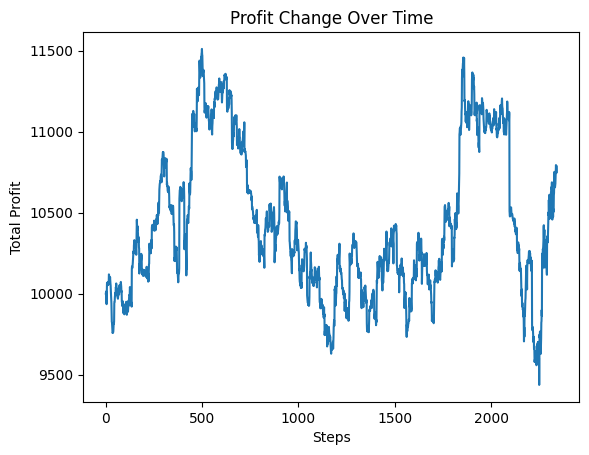

In [54]:
import matplotlib.pyplot as plt

# Plotting the profit change
plt.plot(env.portfolio_history)
plt.title("Profit Change Over Time")
plt.xlabel("Steps")
plt.ylabel("Total Profit")
plt.show()